# Tree detection inference

In [ ]:
# Import required libraries
from pathlib import Path
import torch

from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.detector import (
    DeepForestDetector,
    Detectree2Detector,
    SAMV2Detector,
)
from tree_detection_framework.detection.models import DeepForestModule, Detectree2Module
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)

/home/mich889/miniconda3/envs/sam/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Define constants
The behavior of this notebook can be changed by adjusting these values.

In [3]:
# The path to a folder of raster images, e.g. orthomosaics stor
RASTER_FOLDER_PATH = Path(DATA_FOLDER, "emerald-point-ortho")
RASTER_FILE_PATH = Path(RASTER_FOLDER_PATH, "ortho.tif")
# Prediction file path
OUTPUT_PREDICTIONS_FILE_PATH = Path(
    DATA_FOLDER, "emerald-point-ortho-detectree2-predictions.gpkg"
)
# The size of the chips in pixels
CHIP_SIZE = 1024
# The stride between chips in pixels
CHIP_STRIDE = 768
# The spatial resolution that the data is sampled to in meters/pix
OUTPUT_RESOLUTION = 0.05
# The number of samples in a batch
BATCH_SIZE = 4
# Any detections below this threshold will be discarded
MIN_CONFIDENCE_THRESHOLD = 0.3
# Detections that overlap more than this threshold will be suppressed
IOU_NMS_THESHOLD = 0.3

# How many tiles to show
N_VIS_TILES = 3

# Choose the tree detction model you want to use from: "deepforest" and "detectree2" and "sam2"
TREE_DETECTOR = "sam2"

# Setup the parameters dictionary use DeepForest
DEEPFOREST_MODEL_PARAMS = {
    "backbone": "retinanet",
    "num_classes": 1,
}
# Setup the parameters dictionary use Detectree2
DETECTREE2_MODEL_PARAMS = {
    "update_model": "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"
}
# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Create a dataloader to generate samples

In [4]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
    batch_size=BATCH_SIZE,
)

2025-01-05 14:34:08,786 - INFO - Units = Units.PIXELS
2025-01-05 14:34:08,788 - INFO - Stride = 768


Show example samples

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


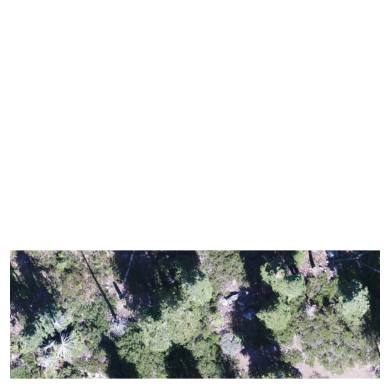

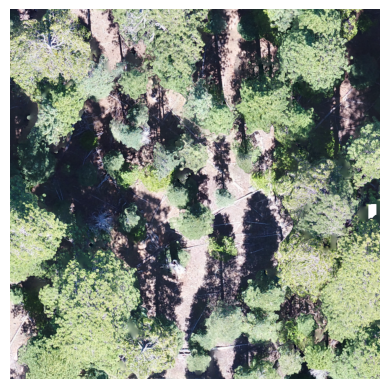

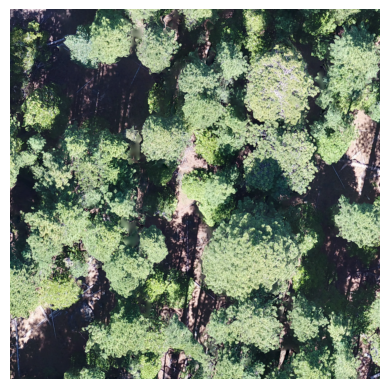

In [4]:
visualize_dataloader(dataloader, n_tiles=N_VIS_TILES)

Create a DeepForest or Detectree2 detector model

In [5]:
# Create the module and detector based on the TREE_DETECTOR selected
if TREE_DETECTOR == "deepforest":

    # This model uses pretrained weights from DeepForest
    module = DeepForestModule(DEEPFOREST_MODEL_PARAMS).to(DEVICE)
    detector = DeepForestDetector(module)

elif TREE_DETECTOR == "detectree2":

    # This model uses pretrained weights from Detectree2
    module = Detectree2Module(DETECTREE2_MODEL_PARAMS)
    detector = Detectree2Detector(module)

elif TREE_DETECTOR == "sam2":

    detector = SAMV2Detector()

Generate predictions for each tile in the dataloader

In [6]:
outputs = detector.predict(dataloader)

Performing prediction on batches:   0%|          | 0/18 [00:00<?, ?it/s]/home/mich889/miniconda3/envs/sam/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
Performing prediction on batches:   0%|          | 0/18 [00:02<?, ?it/s]


RuntimeError: No CUDA GPUs are available

Plot the predictions for all overlapping tiles colored by the prediction confidence

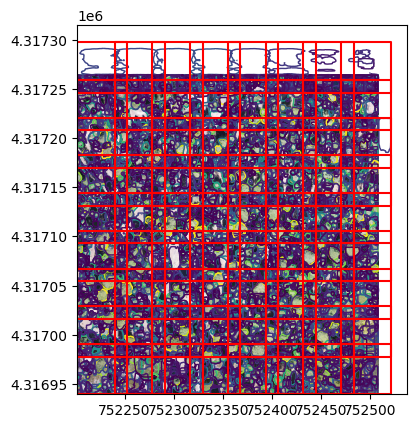

<Axes: >

In [7]:
outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Run nonmax suppression and across all the tiles and remove low-confidence detections

In [8]:
NMS_outputs = multi_region_NMS(
    outputs,
    confidence_column="score",
    iou_theshold=IOU_NMS_THESHOLD,
    min_confidence=MIN_CONFIDENCE_THRESHOLD,
)

2024-11-15 00:27:06,120 - INFO - Bound have overlap, running across-region NMS


Show the result again after running NMS

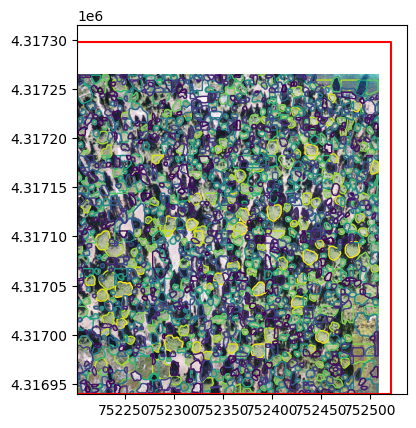

<Axes: >

In [9]:
NMS_outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Save out the predictions to a geospatial file

In [10]:
NMS_outputs.save(OUTPUT_PREDICTIONS_FILE_PATH)

2024-11-15 00:28:24,820 - INFO - Created 1,440 records
